In [1]:
import torch
from torch import tensor

In [2]:
import numpy as np

In [3]:
import sys, inspect
sys.path.insert(0, '..')

In [4]:
%matplotlib inline
# import pymc
import matplotlib.pyplot as plt

# from learn_smc_proposals import cde
# from learn_smc_proposals.utils import systematic_resample

import seaborn as sns
sns.set_context("notebook", font_scale=1.5, rc={"lines.markersize": 12})
sns.set_style('ticks')

import scipy.stats as stats
import scipy.special as special
import scipy

from functools import reduce
from operator import mul

from tqdm import tqdm

import pandas as pd

In [5]:
plt.rcParams["figure.figsize"] = (6,4)

In [6]:
def change_lr(optimizer, lr):
    state_dict = optimizer.state_dict()
    for param_group in state_dict['param_groups']:
        param_group['lr'] = lr
    optimizer.load_state_dict(state_dict)

In [7]:
l = 4
n = 1000
x = np.linspace(-l, l, n)
p = (x>1) * stats.norm(loc=0, scale=1).pdf(x)

q = lambda mu, sigma: stats.norm(loc=mu, scale=sigma).pdf(x)
res = scipy.optimize.minimize(fun=lambda args: stats.entropy(p, q(args[0], args[1])), x0=[1, 1], method='Nelder-Mead')
mu_q, sigma_q = res.x

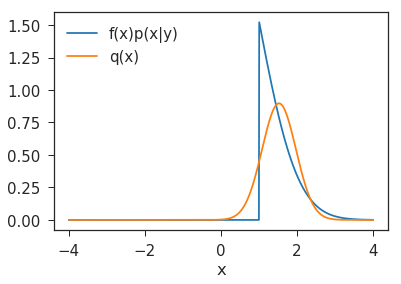

mu_q 1.53, sigma_q 0.44


In [8]:
plt.plot(x, p/sum(p*(2*l/n)), label='f(x)p(x|y)')
plt.plot(x, q(mu_q, sigma_q), label='q(x)')

plt.legend()
plt.xlabel('x')
plt.show()

print("mu_q {:.2f}, sigma_q {:.2f}".format(mu_q, sigma_q))

In PyTorch

In [9]:
l = 4
n = 1000
x = torch.linspace(-l, l, n).to('cuda')

mean = tensor([0.], requires_grad=True, device='cuda')
std = tensor([1.], requires_grad=True, device='cuda')

p = (x<1).float() * -1e38 + torch.distributions.Normal(tensor([0.], device='cuda'), 
                                                       tensor([1.], device='cuda')).log_prob(x)

optimizer = torch.optim.Adam([mean, std], lr = 0.01)

for t in range(500):
    q = torch.distributions.Normal(mean, std).log_prob(x)
    loss = torch.dot(p.exp(), p-q)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
mean, std

(tensor([ 1.5254], device='cuda:0'), tensor([ 0.4445], device='cuda:0'))

# Model

\begin{align}
p(x) &= \mathcal{N}(x; 0, 1) \\
p(y|x) &= \mathcal{N}(y; x, 1) \\
p(x|y) &= \mathcal{N}(x; \frac{y}{2}, \frac{1}{2})\\
q_\phi(x|y) &= \mathcal{N}\left(x; \eta(y; \phi) \right) \\
f(x;\theta) &= \mathbb{1}_{x>\theta}\\
\\
\theta &\sim \text{Uniform}[-5,5]\\
\end{align}

Posterior is determined analytically

Optimizing the objective function
\begin{align}
\mathbb{E}_{p(y)\,p(\theta)}\left[D_{KL} \left[ f(x;\theta) \, p(x|y) \mid\mid q(x|y) \right]\right]
&=& \int D_{KL} \left[ f(x;\theta) \, p(x|y) \mid\mid q(x|y) \right] p(y) p(\theta) \, \text{d}y \, \text{d}\theta \\
&=& \int p(x,y) p(\theta) \, f(x;\theta) \log \frac{f(x;\theta)p(x|y)}{q(x|y;\phi)} \, \text{d}x \, \text{d}y \, \text{d}\theta \\
&=& \text{constant wrt }\phi - \int p(x,y) p(\theta) \, f(x;\theta) \log q(x|y;\phi) \, \text{d}x \, \text{d}y \, \text{d}\theta \\
&=& \mathbb{E}_{p(x,y)\,p(\theta)}\left[-f(x; \theta) \log q(x \mid y;\phi)\right]
\end{align}

In [10]:
batch_size = 30000
epochs = 10000
H = 10

# sharing parameters
# input: y, theta
q_net = torch.nn.Sequential(
          torch.nn.Linear(2, H),
          torch.nn.ReLU(),
          torch.nn.Linear(H, H),
          torch.nn.ReLU(),
          torch.nn.Linear(H, 4),
        )
q_net.to('cuda')

f = lambda x, theta: (x>theta).float()

optimizer = torch.optim.Adam(q_net.parameters(), lr = 0.01)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=1000, gamma=0.1)

In [11]:
# Number of parameters in the model
sum([reduce(mul, list(tensorr.size())) for tensorr in q_net.parameters()])

184

In [12]:
zero = tensor([0.], device='cuda')
one = tensor([1.], device='cuda')

for e in range(epochs):
    theta = (torch.rand(batch_size, 1, device='cuda')-0.5)*10

    x = torch.distributions.Normal(zero, one).sample((batch_size,))
    y = torch.distributions.Normal(   x, one).sample()
    
    q1_mean, q1_log_std, q2_mean, q2_log_std = q_net(torch.cat((y, theta), 1)).split(1, dim=1)
    q1_std, q2_std = q1_log_std.exp(), q2_log_std.exp()
    q1 = torch.distributions.Normal(q1_mean, q1_std)
    q2 = torch.distributions.Normal(q2_mean, q2_std)
    
    loss = 0
    loss += -(f(x, theta) * q1.log_prob(x)).mean()
    loss += -q2.log_prob(x).mean()
    print(e, loss.item()) if e%100==0 else None
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    scheduler.step()

0 2.5444064140319824
100 1.5793265104293823
200 1.5625108480453491
300 1.5618207454681396
400 1.5704623460769653
500 1.5403043031692505
600 1.5682380199432373
700 1.5492708683013916
800 1.5598978996276855
900 1.5709222555160522
1000 1.57054603099823
1100 1.5544869899749756
1200 1.5607199668884277
1300 1.567683458328247
1400 1.5571221113204956
1500 1.5635522603988647
1600 1.555005431175232
1700 1.5575053691864014
1800 1.555224895477295
1900 1.5444896221160889
2000 1.5586975812911987
2100 1.5495243072509766
2200 1.5628948211669922
2300 1.5709247589111328
2400 1.5635597705841064
2500 1.5566893815994263
2600 1.5587806701660156
2700 1.5589100122451782
2800 1.5661547183990479
2900 1.5674936771392822
3000 1.5472052097320557
3100 1.5499451160430908
3200 1.5614590644836426
3300 1.5613383054733276
3400 1.5581510066986084
3500 1.5455923080444336
3600 1.557327151298523
3700 1.5568835735321045
3800 1.5643543004989624
3900 1.5608036518096924
4000 1.561559796333313
4100 1.5581369400024414
4200 1.5690

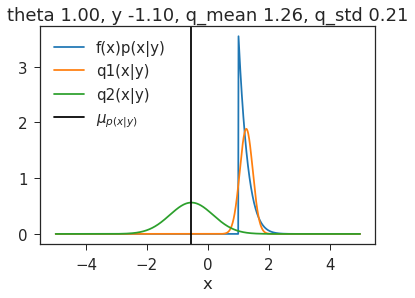

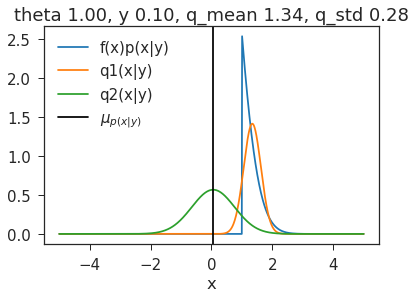

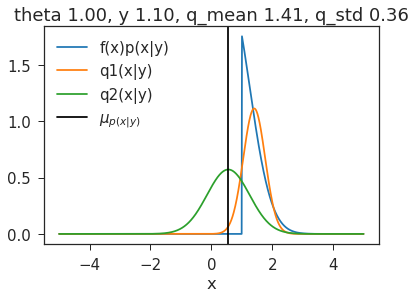

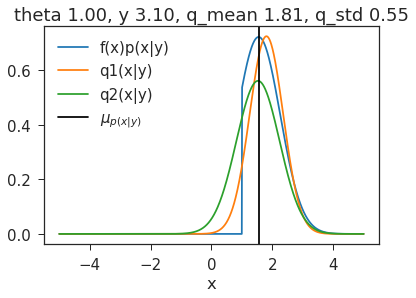

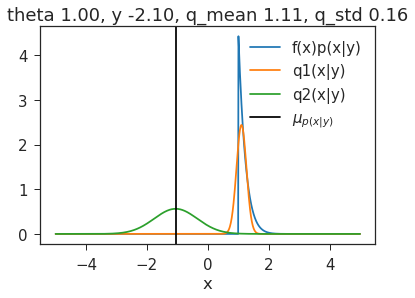

In [13]:
theta = torch.ones(5,1, device='cuda')
y = tensor([[-1.1, 0.1, 1.1, 3.1, -2.1]], device='cuda').transpose(0,1)

q1_mean, q1_log_std, q2_mean, q2_log_std = q_net(torch.cat((y, theta), 1)).split(1, dim=1)
q1_std, q2_std = q1_log_std.exp(), q2_log_std.exp()
q1 = torch.distributions.Normal(q1_mean, q1_std)
q2 = torch.distributions.Normal(q2_mean, q2_std)

l = 5
n = 1000
x = np.linspace(-l, l, n)

q = lambda mu, sigma: stats.norm(loc=mu, scale=sigma).pdf(x)

for itheta, iy, iq1_mean, iq1_std, iq2_mean, iq2_std in zip(*[i.to('cpu').data.numpy().flatten() for i in [theta, y, q1_mean, q1_std, q2_mean, q2_std]]):
    # analytical posterior
    py = (x>itheta) * stats.norm(loc=iy/2, scale=1/np.sqrt(2)).pdf(x)
    
    plt.plot(x, py/sum(py*(2*l/n)), label='f(x)p(x|y)')
    plt.plot(x, q(iq1_mean, iq1_std), label='q1(x|y)')
    plt.plot(x, q(iq2_mean, iq2_std), label='q2(x|y)')
    plt.axvline(x=iy/2, c='black', label='$\mu_{p(x|y)}$')

    plt.legend()
    plt.xlabel('x')
    plt.title('theta {:.2f}, y {:.2f}, q_mean {:.2f}, q_std {:.2f}'.format(itheta, iy, iq1_mean, iq1_std))
    plt.show()

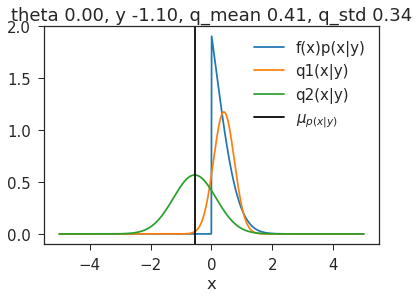

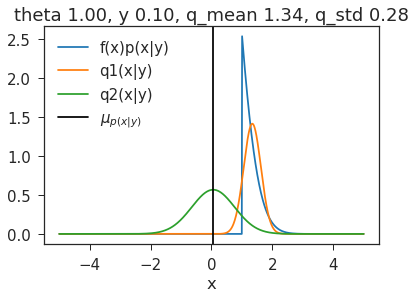

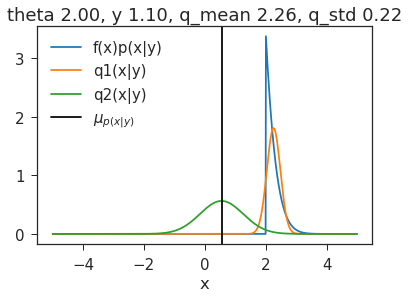

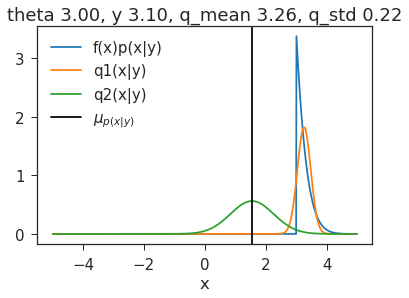

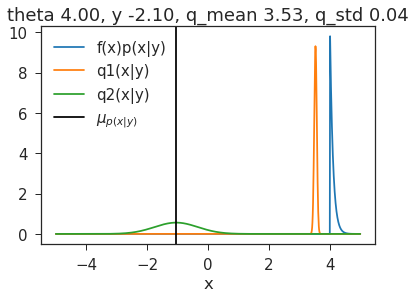

In [14]:
theta = torch.arange(0,5, device='cuda').unsqueeze(1)
y = tensor([[-1.1, 0.1, 1.1, 3.1, -2.1]], device='cuda').transpose(0,1)

q1_mean, q1_log_std, q2_mean, q2_log_std = q_net(torch.cat((y, theta), 1)).split(1, dim=1)
q1_std, q2_std = q1_log_std.exp(), q2_log_std.exp()
q1 = torch.distributions.Normal(q1_mean, q1_std)
q2 = torch.distributions.Normal(q2_mean, q2_std)

l = 5
n = 1000
x = np.linspace(-l, l, n)

q = lambda mu, sigma: stats.norm(loc=mu, scale=sigma).pdf(x)

for itheta, iy, iq1_mean, iq1_std, iq2_mean, iq2_std in zip(*[i.to('cpu').data.numpy().flatten() for i in [theta, y, q1_mean, q1_std, q2_mean, q2_std]]):
    # analytical posterior
    py = (x>itheta) * stats.norm(loc=iy/2, scale=1/np.sqrt(2)).pdf(x)
    
    plt.plot(x, py/sum(py*(2*l/n)), label='f(x)p(x|y)')
    plt.plot(x, q(iq1_mean, iq1_std), label='q1(x|y)')
    plt.plot(x, q(iq2_mean, iq2_std), label='q2(x|y)')
    plt.axvline(x=iy/2, c='black', label='$\mu_{p(x|y)}$')

    plt.legend()
    plt.xlabel('x')
    plt.title('theta {:.2f}, y {:.2f}, q_mean {:.2f}, q_std {:.2f}'.format(itheta, iy, iq1_mean, iq1_std))
    plt.show()

# Estimating $\mathbb{E}[f(x)]$

Optimal sampling proposal
$$\mathbb{E}_{p(x|y)}[f(x)] 
= \frac{\mathbb{E}_{q_1(x|y)} \left[ f(x) \frac{p(x, y)}{q_1(x|y)}\right]}{\mathbb{E}_{q_2(x|y)} \left[ \frac{p(x, y)}{q_2(x|y)} \right] }
= \frac{\sum_n^N f(x_n) \frac{p(x_n, y)}{q_1(x_n|y)}}{\sum_m^N \frac{p(x_m, y)}{q_2(x_m|y)}}
= \frac{\sum_n^N f(x_n) \exp(\log p(x_n, y) - \log q_1(x_n|y))}{\sum_m^N \exp(\log p(x_m, y) - \log q_2(x_m|y))}\\
$$

For $f(x) \ge 0$
$$
\log \mathbb{E}_{p(x|y)}[f(x)] 
= \log \sum_n^N \exp(\log f(x_n) + \log p(x_n, y) - \log q_1(x_n|y)) - \log \sum_m^N \exp(\log p(x_m, y) - \log q_2(x_m|y)) \\
$$

Posterior as a proposal
$$
\mathbb{E}_{p(x|y)}[f(x)] 
= \frac{\mathbb{E}_{q_2(x|y)} \left[ f(x) \frac{p(x, y)}{q_2(x|y)}\right]}
{\mathbb{E}_{q_2(x|y)} \left[ \frac{p(x, y)}{q_2(x|y)}\right]}
$$

In [15]:
from numbers import Number
def log_sum_exp(value, dim=None, keepdim=False):
    """Numerically stable implementation of the operation
    
    Courtesy of JW

    value.exp().sum(dim, keepdim).log()
    """
    # TODO: torch.max(value, dim=None) threw an error at time of writing
    if dim is not None:
        m, _ = torch.max(value, dim=dim, keepdim=True)
        value0 = value - m
        if keepdim is False:
            m = m.squeeze(dim)
        return m + torch.log(torch.sum(torch.exp(value0),
                                       dim=dim, keepdim=keepdim))
    else:
        m = torch.max(value)
        sum_exp = torch.sum(torch.exp(value - m))
        if isinstance(sum_exp, Number):
            return m + math.log(sum_exp)
        else:
            return m + torch.log(sum_exp)

In [16]:
def p_xy_log_prob(x, y):
    log_prob = 0
    log_prob += torch.distributions.Normal(zero, one).log_prob(x)
    log_prob += torch.distributions.Normal(   x, one).log_prob(y)
    return log_prob

In [158]:
y = tensor([[-1.1, 0.1, 1.1, 3.1, -2.1]], device='cuda').transpose(0,1)
theta = torch.ones(5,1, device='cuda')
theta = torch.arange(0,5, device='cuda').unsqueeze(1)
theta = tensor([[0,1,2,3,3]], device='cuda', dtype=torch.float).transpose(0,1)

q1_mean, q1_log_std, q2_mean, q2_log_std = q_net(torch.cat((y, theta), 1)).split(1, dim=1)
q1_std, q2_std = q1_log_std.exp(), q2_log_std.exp()
q1 = torch.distributions.Normal(q1_mean, q1_std)
q2 = torch.distributions.Normal(q2_mean, q2_std)

true_val = 1-scipy.stats.norm.cdf(theta, loc=y/2, scale=1/np.sqrt(2))

iis = np.arange(2, 24)

# plot_xs = 10**iis
plot_xs = 2**iis
plot_ys_op = []
plot_ys_post = []

number_of_tries = 100

fn_error = lambda estimates: np.abs(
    np.exp(estimates.cpu().data.numpy().astype(np.float64)) - true_val)

for no_samples in tqdm(plot_xs):
    temp_ys_op = []
    temp_ys_post = []
    for _ in range(number_of_tries):
        no_samples = int(no_samples)
        samples_x_q1 = q1.sample((no_samples,))
        samples_x_q2 = q2.sample((no_samples,))

        # optimal proposal
        estimates_op =\
        ( log_sum_exp(f(samples_x_q1, theta).log()\
                    + p_xy_log_prob(samples_x_q1, y.unsqueeze(0).expand(samples_x_q1.shape))\
                    - q1.log_prob(samples_x_q1), dim=0)\
        - log_sum_exp(p_xy_log_prob(samples_x_q2, y.unsqueeze(0).expand(samples_x_q2.shape))\
                    - q2.log_prob(samples_x_q2), dim=0))
        
        # posterior
        estimates_post =\
        ( log_sum_exp(f(samples_x_q2, theta).log()\
                    + p_xy_log_prob(samples_x_q2, y.unsqueeze(0).expand(samples_x_q2.shape))\
                    - q2.log_prob(samples_x_q2), dim=0)\
        - log_sum_exp(p_xy_log_prob(samples_x_q2, y.unsqueeze(0).expand(samples_x_q2.shape))\
                    - q2.log_prob(samples_x_q2), dim=0))
        
        temp_ys_op.append(fn_error(estimates_op))
        temp_ys_post.append(fn_error(estimates_post))
        
    plot_ys_op.append(temp_ys_op)
    plot_ys_post.append(temp_ys_post)
    
plot_ys_op = np.array(plot_ys_op)
plot_ys_post = np.array(plot_ys_post)

100%|██████████| 22/22 [04:50<00:00, 13.18s/it]


In [159]:
plot_ys_op = plot_ys_op.transpose((2, 0, 1, 3))
plot_ys_post = plot_ys_post.transpose((2, 0, 1, 3))

In [160]:
def create_data(plot_ys):
    ME = np.log(plot_ys.reshape(-1))
    no_samples = np.log(np.tile(
        (np.expand_dims(plot_xs,1)*np.ones((plot_xs.shape[0], plot_ys.shape[2]))).reshape(-1), 
        plot_ys.shape[0]))
    experiment = (np.expand_dims(np.arange(5), 1)*\
                  np.ones((plot_ys.shape[0], plot_ys.shape[1]*plot_ys.shape[2]))).reshape(-1)
    run_no = np.tile(np.arange(plot_ys.shape[2]), plot_ys.shape[0]*plot_ys.shape[1])
    data = pd.DataFrame(columns=["experiment", "no_samples", "run_no", "ME"],
                       data = np.stack([experiment, no_samples, run_no, ME]).T)
    return data

In [161]:
data1 = create_data(plot_ys_op)
data1['proposal'] = 'optimal'

In [162]:
data2 = create_data(plot_ys_post)
data2['proposal'] = 'posterior'

In [163]:
data = pd.concat([data1, data2])

/homes/agolinsk/utils/miniconda3/envs/py/lib/python3.6/site-packages/seaborn/timeseries.py:183: UserWarning: The tsplot function is deprecated and will be removed or replaced (in a substantially altered version) in a future release.
  warnings.warn(msg, UserWarning)


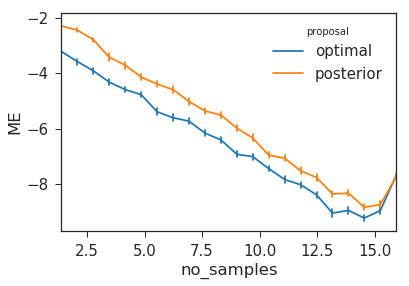

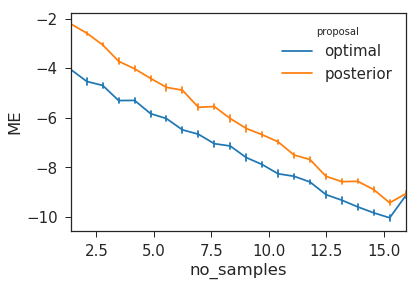

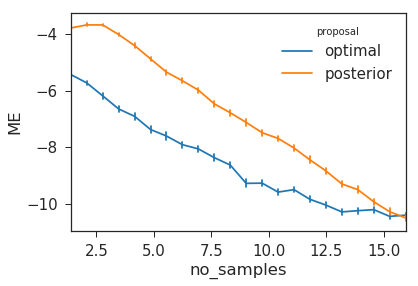

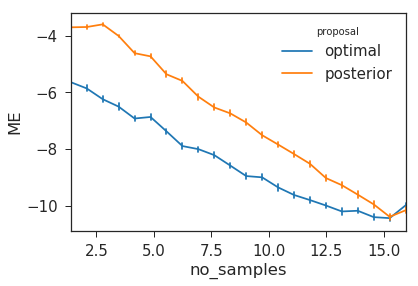

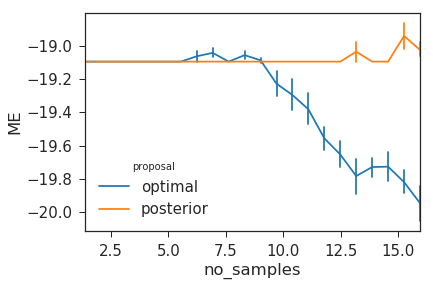

In [164]:
for i in range(5):
    sns.tsplot(data=data[data['experiment']==i], 
               time="no_samples", unit="run_no", condition="proposal", value="ME",
               err_style="ci_bars")
    plt.show()

In [169]:
np.exp(-20), np.finfo(np.float64).resolution

(2.061153622438558e-09, 1e-15)

This weird upward slopt at high number of samples may be because of some numerical issues? I cannot tell really